In [29]:
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, Dropout2d
from torch.autograd import Variable
from torch.optim import Adam, SGD
import torch.nn.functional as F
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd
import os

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #Enable cuda if available

# PART 1. CNN Model

### Step 1. Load data

In [2]:
def get_images_array(imageFile, dataPath):
    with open(imageFile, "r") as f:
        images =  []
        labels = []
        for image in f:
            image =image.replace("\n", "")
            if 'NonCOVID' in imageFile:
                image = imread(dataPath + '/CT_NonCOVID/' + image, as_gray=True)
                image = resize(image, [200, 200])
                image = image.astype('float32')
                image /= 255
                images.append(image)
                labels.append(0) #non-covid
            else:
                image = imread(dataPath + '/CT_COVID/' + image, as_gray=True)
                image = resize(image, [200, 200])
                image = image.astype('float32')
                image /= 255
                images.append(image)
                labels.append(1) #covid
        return images,labels
            

In [27]:
base_dir= '../../../data/CNN'
train_im, train_labels = get_images_array(base_dir+'/Data-split/COVID/trainCT_COVID.txt', base_dir)
train_imNC, train_labels_nc = get_images_array(base_dir+'/Data-split/NonCOVID/trainCT_NonCOVID.txt', base_dir)
train_im.extend(train_imNC)
train_labels.extend(train_labels_nc)

###### X_train, Y_train #########
train_features = np.array(train_im)
train_labels = np.int64(np.array(train_labels))
###### X_train, Y_train #########

test_im, test_labels = get_images_array(base_dir+'/Data-split/COVID/testCT_COVID.txt', base_dir)
test_im_nc, test_labels_nc = get_images_array(base_dir+'/Data-split/NonCOVID/testCT_NonCOVID.txt', base_dir)
test_im.extend(test_im_nc)
test_labels.extend(test_labels_nc)

###### X_test, Y_test #########
test_features = np.array(test_im)
test_labels = np.int64(np.array(test_labels))
###### X_test, Y_test #########

print(train_features.shape)

(425, 200, 200)


### Step 2. Visualize data

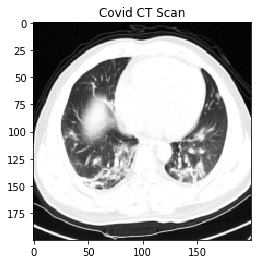

In [51]:
## covid ct scan
index = np.argmax(train_labels)
plt.title("Covid CT Scan")
plt.imshow(train_im[index], 'gray')
assert(np.max(train_labels) == 1)

plt.show()

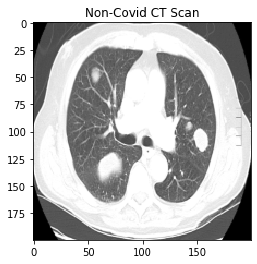

In [10]:
## non-covid ct scan
index = np.argmin(train_labels)
plt.title("Non-Covid CT Scan")
plt.imshow(train_im[index], 'gray')
assert(np.min(train_labels) == 0)
plt.show()

### Step 3. Split data into training, validation, and test sets

In [11]:
train_x, val_x, train_y, val_y = train_test_split(train_features, train_labels, test_size = 0.05)

train_x = train_x.reshape(403, 1, 200, 200)
train_x = torch.from_numpy(train_x)
train_y = torch.from_numpy(train_y)
val_x = val_x.reshape(22, 1, 200, 200)
val_x = torch.from_numpy(val_x)
val_y = torch.from_numpy(val_y)

test_features = test_features.reshape(203, 1, 200, 200)
test_x = torch.from_numpy(test_features)
test_y = torch.from_numpy(test_labels)

print("Training set shape:", train_x.shape)
print("Test set shape:", test_x.shape)
print("Validation set shape:", val_x.shape)

Training set shape: torch.Size([403, 1, 200, 200])
Test set shape: torch.Size([203, 1, 200, 200])
Validation set shape: torch.Size([22, 1, 200, 200])


### Step 4. Build CNN model

In [12]:
class CNN(Module):   
    def __init__(self):
        super(CNN, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 10, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(10),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(10, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(10000, 2)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [13]:
model = CNN()
#Load model
# model.load_state_dict(torch.load("../../models/covid_cnn.pth"))

<All keys matched successfully>

In [14]:
print(model)
optimizer = Adam(model.parameters(), lr=1e-4)
criterion = CrossEntropyLoss()

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

CNN(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(10, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=10000, out_features=2, bias=True)
  )
)


### Step 5. Train model

In [15]:
def train_cnn():
    model.train()
    loss = 0
    trainx = Variable(train_x)
    trainy = Variable(train_y)
    valx = Variable(val_x)
    valy = Variable(val_y)
   
    optimizer.zero_grad()
    train_out = model(trainx)
    val_out = model(valx)
    train_loss = criterion(train_out, trainy)
    val_loss = criterion(val_out, valy)
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    
    train_loss.backward()
    optimizer.step()
    loss = train_loss.item()
    print('Epoch : ',epoch+1, '\t', 'loss :', val_loss.item())
    return val_loss

In [16]:
n_epochs = 50
train_losses = []
val_losses = []

epsilon = 0.36 #stopping condition
for epoch in range(n_epochs):
    train_cnn()
    if(train_losses[-1] <= epsilon): #converged
        print("Model converged with loss", round(train_losses[-1], 6))
        break

Epoch :  1 	 loss : 0.3040322959423065
Model converged with loss 0.326702


### Step 6. Data visualization

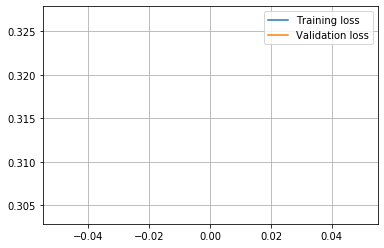

In [17]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.grid()
plt.show()

In [18]:
def accuracy(features, labels):
    with torch.no_grad():
        output = model(features)
    softmax = torch.exp(output).cpu()
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)
    return accuracy_score(labels, predictions)

In [19]:
# accuracy on training set
print("Train ACCURACY", accuracy(train_x, train_y))

Train ACCURACY 0.8660049627791563


In [20]:
# accuracy on validation set
print("Validation accuracy", accuracy(val_x, val_y))

Validation accuracy 0.8636363636363636


In [21]:
# accuracy on test set
print("Test accuracy", accuracy(test_x, test_y))

Test accuracy 0.6206896551724138


In [22]:
#Read more: https://pytorch.org/tutorials/beginner/saving_loading_models.html
torch.save(model.state_dict(), "../../models/covid_cnn.pth")

# PART 2: Conformal Prediction

In [23]:
def euclid(point, centroid):
    """Calculate the distance between a test point and a centroid point"""
    #assuming point and centroid are tensors
    point = np.array(point.tolist())
    centroid = np.array(centroid.tolist())
    return np.linalg.norm(point - centroid)

In [367]:
def centroid(data):
    """Find the centroid for one class of object"""
    height, width, observations = data.shape
    features = height * width
    data = data.reshape(features, observations) #flatten
    central = []
    for i in range(features):
        mean = np.mean(data[i].numpy())
        central.append(mean)
        
    central = np.array(central).reshape(height, width) #resize to image
    return torch.FloatTensor(central.T).to(device)

In [368]:
def split_classes(data, labels):
    """Split data into 2 classes based on corresponding label"""
    covid, non_covid = [], []
    for i in range(data.shape[0]):
        if(labels[i].item() == 0):#non-covid
            non_covid.append(data[i].tolist())
        else:
            covid.append(data[i].tolist())
            
    #type-cast to tensors
    covid = torch.tensor(covid).to(device)        
    non_covid = torch.tensor(non_covid).to(device)
    return covid, non_covid

In [365]:
covid_train, non_covid_train = split_classes(train_x, train_y)
covid_test, non_covid_test = split_classes(test_x, test_y)

In [388]:
### generate centroids

covid_train = np.transpose(covid_train, (1, 0, 2, 3))[0]
non_covid_train = np.transpose(non_covid_train, (1, 0, 2, 3))[0]

T_C = np.transpose(covid_train)
T_NC = np.transpose(non_covid_train)
covid_centroid, non_covid_centroid = centroid(T_C), centroid(T_NC)

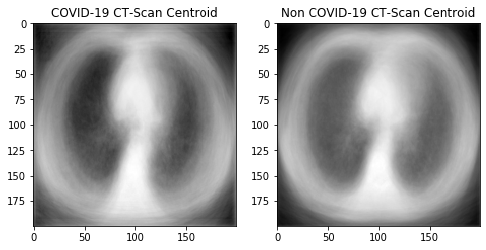

In [389]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1), plt.imshow(covid_centroid, 'gray'), plt.title("COVID-19 CT-Scan Centroid")
plt.subplot(1, 2, 2), plt.imshow(non_covid_centroid, 'gray'), plt.title("Non COVID-19 CT-Scan Centroid")
plt.show()

### Non conformity score

In [390]:
def nonconformity_measure(test_point, label, covid_centroid, non_covid_centroid):
    """Computes the nonconformity score for a single test-point (HELPER method)"""
    covid_dist = euclid(test_point, covid_centroid)
    non_covid_dist = euclid(test_point, non_covid_centroid)
    if(label == 1):#COVID
        return covid_dist/non_covid_dist
    else:
        return non_covid_dist/covid_dist

In [391]:
def subset_nc(testing_data, centroids):
    """Calculate the non-conformity measure for a subset of data"""
    nums = len(testing_data) #number of conformity scores    
    l_c, nl_c = centroids #extract centroid into covid and not_covid centroids
    
    #typecast to tensor
    testing_data = Variable(testing_data)
    y_pred = model(testing_data)

    predictions = [x.argmax().item() for x in y_pred]
    non_conformity_scores = [nonconformity_measure(testing_data[i], predictions[i], l_c, nl_c) for i in range(nums)]
    return torch.FloatTensor(non_conformity_scores).to(device)

In [392]:
def compute_p_value(data, labels, centroid, nc_scores):
    """Calculate p-value from a distribution on non-conformity scores"""
    #compute the conformity scores of dataset first (this will be the training data)
    #after this, use the conformal function to determine p-value: #{j = 1,...,n: alpha_j ≥ alpha_n}/N
    N = len(labels)
    lc, nlc = centroid
    non_conformity_scores = [nonconformity_measure(data[i], labels[i], lc, nlc) for i in range(N)]
    output = []
    for test_nc in nc_scores:
        scores = 0
        for j in range(len(non_conformity_scores)):
            if(non_conformity_scores[j] >= test_nc):
                scores += 1

        p_value = scores/N
        output.append(p_value)
        
    return torch.FloatTensor(output).to(device)

In [408]:
nc_scores = subset_nc(test_x, (covid_centroid, non_covid_centroid))

In [409]:
p_values = compute_p_value(train_x, train_y, (covid_centroid, non_covid_centroid), nc_scores)

In [410]:
def get_error(p_values, epsilon_start, epsilon_end, labels, test_data):
    """Computes the error at a particular significance level(epislon) on the test data based on p-values"""
    y_pred = model(test_data)
    predictions = [x.argmax().item() for x in y_pred] #compute predictions.
    confidence = 1 - p_values
    score = 0
    tots = np.size(np.where((confidence < epsilon_end) & (confidence >= epsilon_start)))
    for prediction, label, conf in zip(predictions, labels, confidence):
        
        if(prediction == label and epsilon_start <= conf < epsilon_end):
            score += 1/tots

    print(f"{epsilon_start*100}% confidence yields {np.round(score*100,3)}% accuracy")
    return score*100, tots

In [414]:
error = []
samples = []
N = 10
for i in range(0, N):
    score, tots = get_error(p_values, i/N, (i+1)/N, test_y, test_x)
    if(tots > 0):
        error.append(score)
        samples.append(tots)

0.0% confidence yields 50.0% accuracy
10.0% confidence yields 80.0% accuracy
20.0% confidence yields 86.957% accuracy
30.0% confidence yields 64.0% accuracy
40.0% confidence yields 61.29% accuracy
50.0% confidence yields 71.429% accuracy
60.0% confidence yields 60.0% accuracy
70.0% confidence yields 42.857% accuracy
80.0% confidence yields 28.0% accuracy
90.0% confidence yields 62.5% accuracy


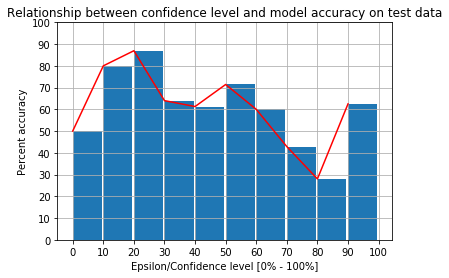

In [415]:
plt.bar(np.arange(0, 100, 100//N), error, width=100//N - .5, align='edge')
plt.plot(np.arange(0, 100, 100//N), error, 'red')
plt.yticks(np.arange(0, 110, 10))
plt.xticks(np.arange(0, 110, 100//N))
plt.xlabel("Epsilon/Confidence level [0% - 100%]")
plt.ylabel("Percent accuracy")
plt.title("Relationship between confidence level and model accuracy on test data")
plt.grid()
plt.show()

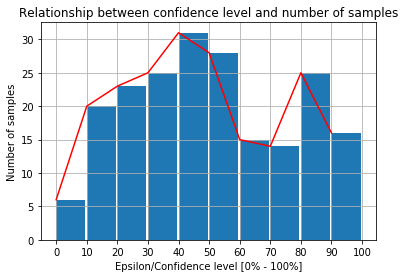

In [416]:
plt.bar(np.arange(0, 100, 100//N), samples, width=100//N - .5, align='edge')
plt.plot(np.arange(0, 100, 100//N), samples, 'red')
plt.xticks(np.arange(0, 110, 100//N))
plt.xlabel("Epsilon/Confidence level [0% - 100%]")
plt.ylabel("Number of samples")
plt.title("Relationship between confidence level and number of samples")
plt.grid()
plt.show()

In [ ]:
### end.